In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit

In [2]:
#file name
fname="haba.tsv"
#assay date & name
asname="21xxxx_haba_assay"

In [3]:
test=[]
with open(fname) as file:
    tsv_file=csv.reader(file,delimiter='\t')
    for line in tsv_file:
        test.append(line)
        
num=int((test.count([])/2)+1)
if num==1:
    line_num=len(test)
else:
    line_num=test.index([])

data=[]
for i in range(num):
    data.append(test[i*(line_num+2):line_num+i*(line_num+2)])

dfs=[]
for i in range(num):
    df=pd.DataFrame(data[i])
    df.columns=[data[i][2][0],data[i][0][0]]
    df=df.drop(df.index[0:3])
    df=df.astype({data[i][2][0]:int,
                  data[i][0][0]:np.float})
    dfs.append(df)
    if i>0:
        dfs[i].drop(data[i][2][0],axis='columns',inplace=True)

result=pd.concat(dfs,axis=1)
result=result.reset_index(drop=True)

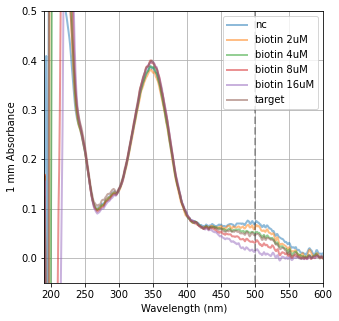

In [4]:
fig, ax=plt.subplots(figsize=(5,5))
x=result.loc[:,['Wavelength (nm)']]

yval=result.drop(["Wavelength (nm)"],axis=1)

for i in yval.columns:
    y=yval.loc[:,[i]]
    ax.plot(x,y,label=i, alpha=0.5, linewidth=2)

#haba-biotin
plt.axvline(500, color='black', linestyle='--', linewidth=2, alpha=0.3)

plt.ylim (-0.05,0.5)
plt.xlim (190,600)
plt.xlabel('Wavelength (nm)')
plt.ylabel('1 mm Absorbance')
plt.legend()
plt.grid(True)
plt.savefig(asname+'.png')
plt.show()

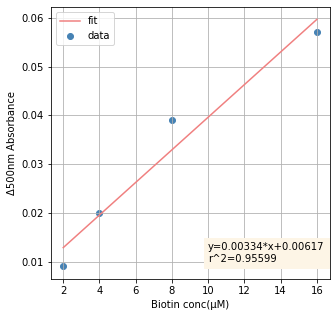

In [5]:
abs_data=[]
for j in yval.columns:
    abs_data.append(yval.loc[500-x.loc[0][0],[j]].values)

abs_nc=yval.loc[500-x.loc[0][0],yval.columns.str.contains('nc')].values

delta500=pd.DataFrame(abs_nc-abs_data,index=yval.columns.values,columns=['Δ500nm Absorbance'])
calibrate=delta500[delta500.index.str.contains('biotin')]
new_y=calibrate.values
new_y=np.ravel(new_y)
new_x=calibrate.index.str.extract('(\d+)')
new_x=np.ravel(new_x)
new_x = new_x.astype('float')

def func(x, a, b):
    return a*x+b
popt, pcov = curve_fit(func, new_x, new_y)

residuals = new_y- func(new_x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((new_y-np.mean(new_y))**2)
r_squared = 1 - (ss_res / ss_tot)

fig, ax=plt.subplots(figsize=(5,5))
ax.scatter(new_x, new_y,color='steelblue',label='data')
ax.plot(new_x,func(new_x,*popt),color='lightcoral',label='fit')

plt.text(10,0.01,'y='+str(round(popt[0],5))
         +'*x+'+str(round(popt[1],5))
         +'\n'+'r^2='+str(round(r_squared,5)),bbox={'color':'oldlace'})
plt.xlabel('Biotin conc(μM)')
plt.ylabel('Δ500nm Absorbance')
plt.legend()
plt.grid(True)
plt.savefig(asname+'calibration.png')
plt.show()

In [6]:
value=delta500[(delta500.index.str.contains('pbs')==False) &
        (delta500.index.str.contains('nc')==False) &
        (delta500.index.str.contains('biotin')==False)]

val=value.values
val=np.ravel(val)

def cal (a,b,c):
    return (a-b)/c

cal_result=[]

for i in range(len(val)):
    cal_result.append(cal(val[i],popt[1],popt[0]))
final=pd.DataFrame(cal_result,index=value.index.values,columns=['Biotin conc.(µM)'])
final.to_csv(asname+'_final.csv',encoding='utf-8')
final

,Biotin conc.(µM)
target,5.630689
